# Extracting Data from Reddit with Pushshift<div class='tocSkip'/>

&copy; Jens Albrecht

This notebook can be freely copied and modified.
Attribution, however, is highly appreciated.

<hr>

This notebook illustrates how to download data from Reddit using the Pushshift API.

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [3]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/jsalbr/tdwi-2021-text-mining/raw/master'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [4]:
%run "$BASE_DIR/notebooks/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)
pd.options.plotting.backend = "matplotlib"

# path to import blueprints packages
sys.path.append('./packages')

# Extract Data from Reddit with Pushshift API


**Pushshift REST API**  
https://github.com/pushshift/api

**PRAW: The Python Reddit API Wrapper**  
https://praw.readthedocs.io/en/latest/

**PSAW: Python Pushshift.io API Wrapper**  
https://github.com/dmarx/psaw  
https://psaw.readthedocs.io/en/latest/

## Filtering Subreddits

List of car subreddits, copied from `subreddit_info.csv` from the [Kaggle Reddit Selfpost dataset](https://www.kaggle.com/mswarbrickjones/reddit-selfposts).

In [27]:
subreddits = """
GolfGTI
Volkswagen
Audi
AskMechanics
MechanicAdvice
mechanics
BMW
E30
Cartalk
askcarsales
autorepair
cars
motorcycles
projectcar
whatcarshouldIbuy
whichbike
volt
FiestaST
FocusST
Ford
FordFocus
Mustang
f150
fordranger
MotoUK
Harley
Honda
civic
Hyundai
CherokeeXJ
GrandCherokee
Jeep
Wrangler
Lexus
Miata
mazda
mazda3
mercedes_benz
MINI
MPSelectMiniOwners
Porsche
saab
SubaruForester
WRX
XVcrosstrek
subaru
teslamotors
4Runner
Toyota
ToyotaTacoma
ft86
prius
Trucks
Volvo
""".strip().replace('\n', ',')

subreddits

'GolfGTI,Volkswagen,Audi,AskMechanics,MechanicAdvice,mechanics,BMW,E30,Cartalk,askcarsales,autorepair,cars,motorcycles,projectcar,whatcarshouldIbuy,whichbike,volt,FiestaST,FocusST,Ford,FordFocus,Mustang,f150,fordranger,MotoUK,Harley,Honda,civic,Hyundai,CherokeeXJ,GrandCherokee,Jeep,Wrangler,Lexus,Miata,mazda,mazda3,mercedes_benz,MINI,MPSelectMiniOwners,Porsche,saab,SubaruForester,WRX,XVcrosstrek,subaru,teslamotors,4Runner,Toyota,ToyotaTacoma,ft86,prius,Trucks,Volvo'

## Using PushshiftAPI for Data Extraction

In [1]:
from datetime import datetime

def unix_timestamp(date):
    """Helper function for timestamp conversion"""
    date = datetime.strptime(date, "%d/%m/%Y %H:%M:%S")
    return int(datetime.timestamp(date))
                                  
date = '18/05/2021 00:00:00'

print(date, unix_timestamp(date))

18/05/2021 00:00:00 1621288800


Takes about an hour or two to extract five months of data in this example.

In [14]:
from psaw import PushshiftAPI
from psaw.PushshiftAPI import log as logger

import json
import logging
import pprint as pp

# fields = "subreddit,id,title,selftext,permalink,link_flair_text,author,created_utc,num_comments,score,is_self"
fields = "subreddit,id,title,selftext,permalink,link_flair_text,author,created_utc,num_comments,score,is_self"
fields = fields.split(','),

params = dict(
    subreddit = subreddits,
    after  = unix_timestamp("01/01/2021 00:00:00"),
    before = unix_timestamp("01/06/2021 00:00:00"),
    fields = fields,
    is_self = True,
    sort = "asc",
    # limit = 20
)

logging.basicConfig(level=logging.ERROR)
logger.setLevel(logging.ERROR) 

api = PushshiftAPI()

if params.get('limit', 50) < 50:
    # if only a few records are loaded, display the output here
    pp.pprint([s.d_ for s in api.search_submissions(**params)])
else:
    # otherwise write the output to a json file
    print("Extracting submissions ...")
    with open("reddit-autos-selfposts.json", "w") as file:
        for s in api.search_submissions(**params):
            _ = file.write(json.dumps(s.d_)+'\n')

Extracting submissions ...


# Convert and Rename Raw Data

In [8]:
df = pd.read_json(f"{BASE_DIR}/data/reddit-autos-selfposts-full.json", lines=True)
len(df)

142946

In [9]:
df.columns

Index(['author', 'created_utc', 'id', 'is_self', 'num_comments', 'permalink',
       'score', 'selftext', 'subreddit', 'title', 'created',
       'link_flair_text'],
      dtype='object')

In [10]:
df[['subreddit', 'title', 'selftext']].sample(3)

,subreddit,title,selftext
61405,Hyundai,2022 Hyundai Kona N performance crossover teased with no camouflage,"Here are the newest photos released from Hyundai for the Kona N. \n\nIm excited but if there is no AWD option, my interest is greatly reduced."
44406,AskMechanics,Head gasket vs radiator help,"Hi,\n\nI have a 2014 Chevy captiva, v6, and 100k miles. A recent (1 year ago) accident caused some front end damage. At the time it was not fixed. Recently it over heated up to 220 degrees after d..."
55416,teslamotors,New to Tesla and have a quick question about the Mobile Charger and Wall Connector for Model 3,[removed]


Only Selfposts with minimum length (automatically excludes `[REMOVED]` posts).

## Filter Selfposts and Subreddits

In [12]:
df = df[df['is_self'] & (df['selftext'].str.len() > 20)]
len(df)

116743

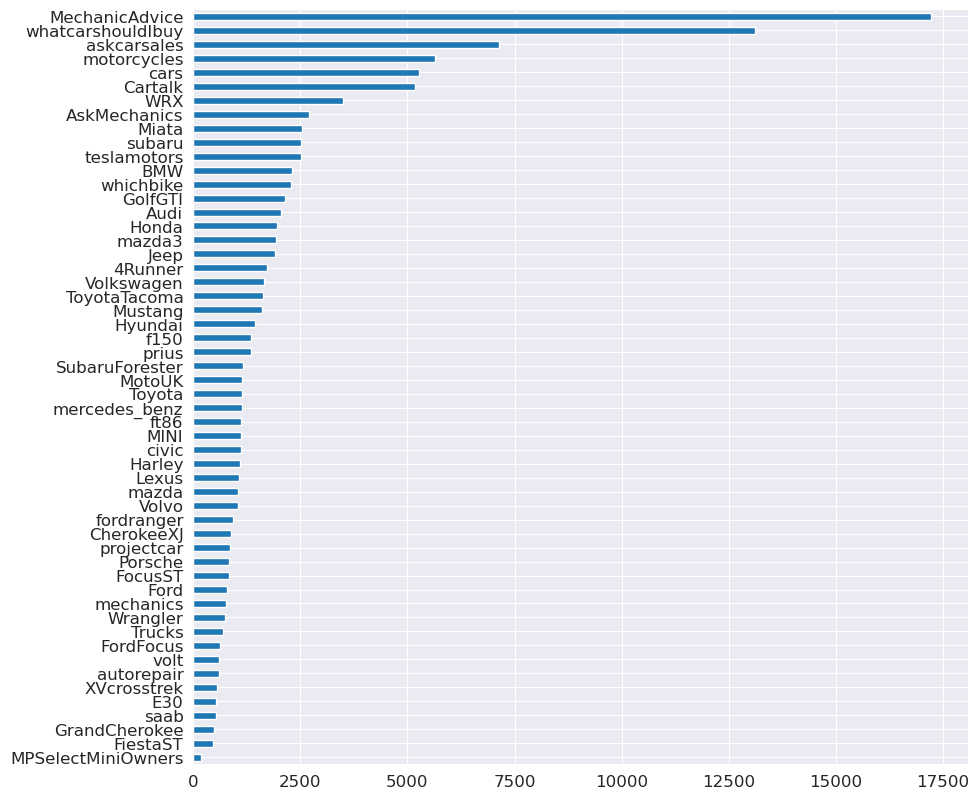

In [16]:
df['subreddit'].value_counts().plot(kind='barh', figsize=(10,10)).invert_yaxis()

In [17]:
subreddits = [
    'motorcycles', 'teslamotors', 'BMW', 'AskMechanics', 'Audi', 'Honda', 
    'Volkswagen', 'Hyundai', 'Harley', 'Toyota', 'Volvo', 'mercedes_benz' 
]

df = df[df['subreddit'].isin(subreddits)].reset_index(drop=True)
len(df)

24712

In [18]:
from datetime import datetime

df['created'] = df['created_utc'].map(datetime.fromtimestamp)
df['created'].describe()

count                   24712
unique                  24671
top       2021-04-15 03:19:22
freq                        2
first     2021-01-01 00:05:03
last      2021-05-31 23:51:36
Name: created, dtype: object

In [19]:
df['day'] = df['created'].dt.date
df['week'] = df['created'].dt.strftime("%Y/Week %W")
# df['year'] = df['created'].dt.year

df[['created', 'day', 'week']].sample(10)

,created,day,week
6012,2021-02-11 04:05:03,2021-02-11,2021/Week 06
16644,2021-04-25 20:06:47,2021-04-25,2021/Week 16
8932,2021-03-04 00:54:40,2021-03-04,2021/Week 09
15439,2021-04-20 11:49:23,2021-04-20,2021/Week 16
11985,2021-03-31 21:19:25,2021-03-31,2021/Week 13
17402,2021-04-29 03:09:51,2021-04-29,2021/Week 17
20898,2021-05-14 15:41:02,2021-05-14,2021/Week 19
10563,2021-03-15 00:07:19,2021-03-15,2021/Week 11
22519,2021-05-21 18:30:57,2021-05-21,2021/Week 20
5855,2021-02-10 08:27:52,2021-02-10,2021/Week 06


<AxesSubplot:>

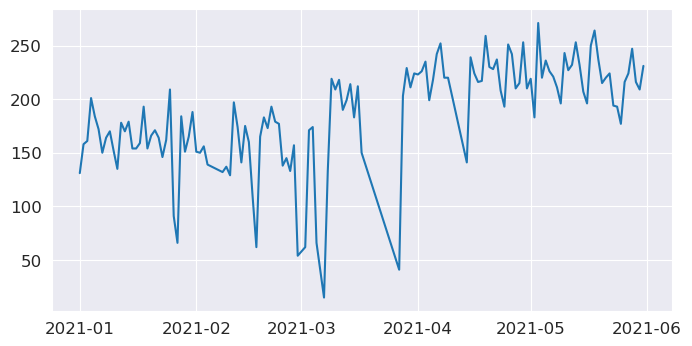

In [20]:
# df['day'].value_counts().sort_index().rolling(window=10, center=True).mean().plot(kind='line')
df['day'].value_counts().sort_index().plot(kind='line')

In [26]:
df['url'] = 'https://www.reddit.com' + df['permalink']

## Rename and Filter Attributes

In [27]:
# for c in df.columns:
#     print(f"    '{c}': '{c}',")

In [28]:
column_mapping = {
    'subreddit': 'subreddit',
    'id': 'id',
    'created_utc': None,
    'created': 'created',
    'author': None,
    'title': 'title',
    'selftext': 'text',
    'num_comments': 'num_comments',
    'score': None,
    'permalink': None,
    'url': 'url',
    'is_self': None,
    'link_flair_text': None
}

# define remaining columns
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]

# select and rename those columns
df = df[columns].rename(columns=column_mapping)

In [29]:
df.head(10)

,subreddit,id,created,title,text,num_comments,url
0,motorcycles,ko049k,2021-01-01 00:05:03,Help! Plastic melted to exhaust,"Title says it all, chrome pipes marred with plastic from a shopping bag that got too close. I've seen different suggestions on various forums, looking for firsthand experience, what's worked best...",9,https://www.reddit.com/r/motorcycles/comments/ko049k/help_plastic_melted_to_exhaust/
1,Toyota,ko0c1i,2021-01-01 00:17:53,Can I please get some help searching online for a used car to buy?,I would really appreciate it. I find this quite overwhelming. My price range is $3000-4000. I know it’s not much but I’m recently back from living abroad for the last 5 years so starting over. \n\...,2,https://www.reddit.com/r/Toyota/comments/ko0c1i/can_i_please_get_some_help_searching_online_for_a/
2,Honda,ko0ci9,2021-01-01 00:18:40,Can I please get some help searching online for a used car to buy?,I would really appreciate it. I find this quite overwhelming. My price range is $3000-4000. I know it’s not much but I’m recently back from living abroad for the last 5 years so starting over. \n\...,4,https://www.reddit.com/r/Honda/comments/ko0ci9/can_i_please_get_some_help_searching_online_for_a/
3,Audi,ko0e4y,2021-01-01 00:21:32,2018 A4 Apple CarPlay issue,"The apple CarPlay thing on my car works weirdly that it sometimes connect then go off, even with cable connected, and then it says “no device is connected which supports the Audi smartphone interf...",4,https://www.reddit.com/r/Audi/comments/ko0e4y/2018_a4_apple_carplay_issue/
4,teslamotors,ko0fm7,2021-01-01 00:23:50,What do you need to do to get an eMMC chip replacement?,"My household has 2x 2013 Model S, both of which have started having MCU issues in the past half year. We are talking restarting, screen flickering off, visual glitches, no 3G or map downloading, a...",20,https://www.reddit.com/r/teslamotors/comments/ko0fm7/what_do_you_need_to_do_to_get_an_emmc_chip/
5,teslamotors,ko0hh1,2021-01-01 00:26:57,Can the y fit a few pairs of skis without folding down the 2nd row?,The 5 seater not the 7,17,https://www.reddit.com/r/teslamotors/comments/ko0hh1/can_the_y_fit_a_few_pairs_of_skis_without_folding/
6,Audi,ko0jvu,2021-01-01 00:31:07,Tips or experiences to share with painting their Audi?,"I have a beautiful 2019 A5 Sportsback premium plus. But I bought it in white a color I wasn’t sure I’d love. A year later and I’m thinking for selling the car, and I think the color is a significa...",4,https://www.reddit.com/r/Audi/comments/ko0jvu/tips_or_experiences_to_share_with_painting_their/
7,Volvo,ko0ktn,2021-01-01 00:32:45,Anyone do a full LED swap on their P3 S60?,"I've successfully swapped out my headlights and high beams for LEDs on my 2015.5 S60. I'm also looking to do my turn signals (front and rear), brake lights, reverse lights, and interior lighting. ...",3,https://www.reddit.com/r/Volvo/comments/ko0ktn/anyone_do_a_full_led_swap_on_their_p3_s60/
8,teslamotors,ko0odc,2021-01-01 00:38:49,"Here it is... Everything I've done to get a Tesla Model 3, as a 17-year-old.","**I posted this a month ago but forgot to share it here, it would mean a lot if you guys checked it out, took me a while to edit!!**\n\nInstagram: https://www.instagram.com/yousif.mihyar \n\nThank...",0,https://www.reddit.com/r/teslamotors/comments/ko0odc/here_it_is_everything_ive_done_to_get_a_tesla/
9,teslamotors,ko13vz,2021-01-01 01:05:04,Tesla Should Buy Ford,"Okay, so I'm not the first one to think of this. Here are a couple recent articles bringing this up.\n\n[https://fordauthority.com/2020/12/tesla-open-to-merger-with-traditional-automaker-should-it...",25,https://www.reddit.com/r/teslamotors/comments/ko13vz/tesla_should_buy_ford/


## Save the Data Frame


In [30]:
# df.to_json("reddit-autos-selfposts-raw.json", orient='records', lines='true')

In [31]:
df.to_csv("reddit-autos-selfposts-raw.csv", sep=";", decimal=".", index=False)